This notebook implements the hierarchical classification pipeline:

Stage 1 (Coarse): Anatomical region localization (brain, abdomen, chest)
Stage 2 (Fine): Region-specific pathology classification
Stage 3 (Subtype): Disease subtype identification (optional)


In [1]:
import sys
sys.path.append('..')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt

from utils.hierarchical_model import HierarchicalClassificationModel
from utils.coarse_classifier import CoarseAnatomicalClassifier
from utils.fine_classifier import RegionSpecificPathologyNetwork
from utils.data_loader import get_medmnist_dataloaders, create_hierarchical_dataset
from utils.trainer import Trainer
from utils.metrics import compute_metrics, compute_hierarchical_metrics
from utils.visualization import (
    plot_training_history,
    plot_hierarchical_results,
    plot_confusion_matrix
)
from config import *

print(f"Device: {DEVICE}")
set_seed(42)

Device: cuda


In [2]:
# Load OrganMNIST3D dataset
train_loader, val_loader, test_loader, num_classes = get_medmnist_dataloaders(
    dataset_name='organ',
    batch_size=DATA_CONFIG['batch_size'],
    num_workers=DATA_CONFIG['num_workers']
)

print(f"Total organ classes: {num_classes}")
print(f"Training samples: {len(train_loader.dataset)}")

# Create organ-to-region mapping
ORGAN_TO_REGION_IDX = {
    'abdomen': 0,
    'chest': 1,
    'bone': 2,
}

REGION_IDX_TO_NAME = {v: k for k, v in ORGAN_TO_REGION_IDX.items()}

# Map organ classes to region indices
organ_to_region_map = {}
for organ_idx, organ_name in ORGAN_CLASSES.items():
    region_name = ORGAN_TO_REGION[organ_name]
    region_idx = ORGAN_TO_REGION_IDX[region_name]
    organ_to_region_map[organ_idx] = region_idx

print("\nOrgan to Region mapping:")
for organ_idx, organ_name in ORGAN_CLASSES.items():
    region_idx = organ_to_region_map[organ_idx]
    region_name = REGION_IDX_TO_NAME[region_idx]
    print(f"  {organ_name:15s} -> {region_name}")

Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Total organ classes: 11
Training samples: 971

Organ to Region mapping:
  bladder         -> abdomen
  femur-left      -> bone
  femur-right     -> bone
  heart           -> chest
  kidney-left     -> abdomen
  kidney-right    -> abdomen
  liver           -> abdomen
  lung-left       -> chest
  lung-right      -> chest
  pancreas        -> abdomen
  spleen          -> abdomen


In [3]:
print("="*60)
print("STAGE 1: Coarse Anatomical Region Classification")
print("="*60)

# Create coarse classifier with new architecture options
from utils.cnn_3d_models import get_3d_model

num_regions = len(ORGAN_TO_REGION_IDX)
architecture = MODEL_CONFIG['coarse_architecture']  # Use coarse-specific architecture

# Create coarse classifier
coarse_model = CoarseAnatomicalClassifier(
    architecture=architecture,
    num_regions=num_regions,
    dropout_rate=MODEL_CONFIG['dropout_rate'],
    region_names=REGION_IDX_TO_NAME
).to(DEVICE)

print(f"\n Using {architecture.upper().replace('_', '-')} for Stage 1 (Coarse)")
print(f"Number of anatomical regions: {num_regions}")
print(f"Regions: {list(ORGAN_TO_REGION_IDX.keys())}")
print(f"Region index mapping: {REGION_IDX_TO_NAME}")

# Count parameters
coarse_params = sum(p.numel() for p in coarse_model.parameters())
print(f"Model parameters: {coarse_params:,}")
print(f"\n To change architecture, edit MODEL_CONFIG['coarse_architecture'] in config.py")

STAGE 1: Coarse Anatomical Region Classification

 Using RESNET34-3D for Stage 1 (Coarse)
Number of anatomical regions: 3
Regions: ['abdomen', 'chest', 'bone']
Region index mapping: {0: 'abdomen', 1: 'chest', 2: 'bone'}
Model parameters: 63,471,171

 To change architecture, edit MODEL_CONFIG['coarse_architecture'] in config.py


In [4]:
# Custom data loader that converts organ labels to region labels
class RegionDataLoader:
    def __init__(self, data_loader, organ_to_region_map):
        self.data_loader = data_loader
        self.organ_to_region_map = organ_to_region_map
    
    def __iter__(self):
        for images, organ_labels in self.data_loader:
            # Convert organ labels to region labels
            # Flatten to 1D to handle both single and batch cases
            organ_labels_flat = organ_labels.view(-1)
            region_labels = torch.tensor([
                self.organ_to_region_map[label.item()]
                for label in organ_labels_flat
            ]).unsqueeze(-1)
            yield images, region_labels
    
    def __len__(self):
        return len(self.data_loader)
    
    @property
    def dataset(self):
        return self.data_loader.dataset

# Wrap data loaders
coarse_train_loader = RegionDataLoader(train_loader, organ_to_region_map)
coarse_val_loader = RegionDataLoader(val_loader, organ_to_region_map)
coarse_test_loader = RegionDataLoader(test_loader, organ_to_region_map)

print("Region-labeled data loaders created")

Region-labeled data loaders created


In [ ]:
# Setup training for Stage 1

torch.cuda.empty_cache()

coarse_criterion = nn.CrossEntropyLoss()
coarse_optimizer = optim.Adam(
    coarse_model.parameters(),
    lr=TRAINING_CONFIG['learning_rate'],
    weight_decay=TRAINING_CONFIG['weight_decay']
)
coarse_scheduler = StepLR(
    coarse_optimizer,
    step_size=TRAINING_CONFIG['scheduler_step_size'],
    gamma=TRAINING_CONFIG['scheduler_gamma']
)

coarse_trainer = Trainer(
    model=coarse_model,
    train_loader=coarse_train_loader,
    val_loader=coarse_val_loader,
    criterion=coarse_criterion,
    optimizer=coarse_optimizer,
    device=DEVICE,
    scheduler=coarse_scheduler
)

# Train Stage 1
print("\nTraining Stage 1: Coarse Region Classifier...\n")
coarse_history = coarse_trainer.train(num_epochs=TRAINING_CONFIG['coarse_epochs'])

print("\nStage 1 Training Complete!")
print(f"Best validation accuracy: {max(coarse_history['val_acc']):.4f}")


Training Stage 1: Coarse Region Classifier...


Epoch 1/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 24.41it/s]


Train Loss: 0.9302, Train Acc: 0.6571
Val Loss: 31.1067, Val Acc: 0.2484
New best validation accuracy: 0.2484

Epoch 2/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.03it/s]


Train Loss: 0.5611, Train Acc: 0.7930
Val Loss: 0.2849, Val Acc: 0.8634
New best validation accuracy: 0.8634

Epoch 3/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 25.84it/s]


Train Loss: 0.3470, Train Acc: 0.8651
Val Loss: 0.2397, Val Acc: 0.9006
New best validation accuracy: 0.9006

Epoch 4/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 25.98it/s]


Train Loss: 0.3194, Train Acc: 0.8980
Val Loss: 0.3304, Val Acc: 0.8696

Epoch 5/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 25.83it/s]


Train Loss: 0.2317, Train Acc: 0.9145
Val Loss: 0.2848, Val Acc: 0.8882

Epoch 6/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.90it/s]


Train Loss: 0.2547, Train Acc: 0.9104
Val Loss: 0.1654, Val Acc: 0.9255
New best validation accuracy: 0.9255

Epoch 7/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.43it/s]


Train Loss: 0.2720, Train Acc: 0.8991
Val Loss: 0.1175, Val Acc: 0.9565
New best validation accuracy: 0.9565

Epoch 8/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.80it/s]


Train Loss: 0.1928, Train Acc: 0.9320
Val Loss: 0.2772, Val Acc: 0.9379

Epoch 9/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 25.72it/s]


Train Loss: 0.2249, Train Acc: 0.9207
Val Loss: 0.1598, Val Acc: 0.9255

Epoch 10/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 25.30it/s]


Train Loss: 0.1579, Train Acc: 0.9454
Val Loss: 0.2501, Val Acc: 0.8882

Epoch 11/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.71it/s]


Train Loss: 0.0837, Train Acc: 0.9701
Val Loss: 0.0243, Val Acc: 0.9876
New best validation accuracy: 0.9876

Epoch 12/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.30it/s]


Train Loss: 0.0556, Train Acc: 0.9804
Val Loss: 0.3558, Val Acc: 0.9193

Epoch 13/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.04it/s]


Train Loss: 0.0667, Train Acc: 0.9784
Val Loss: 0.0990, Val Acc: 0.9627

Epoch 14/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.44it/s]


Train Loss: 0.0828, Train Acc: 0.9650
Val Loss: 0.1901, Val Acc: 0.9130

Epoch 15/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.50it/s]


Train Loss: 0.0462, Train Acc: 0.9825
Val Loss: 0.0808, Val Acc: 0.9752

Epoch 16/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 25.14it/s]


Train Loss: 0.0816, Train Acc: 0.9732
Val Loss: 0.1705, Val Acc: 0.9441

Epoch 17/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.80it/s]


Train Loss: 0.0605, Train Acc: 0.9835
Val Loss: 0.0334, Val Acc: 0.9814

Epoch 18/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 25.85it/s]


Train Loss: 0.0438, Train Acc: 0.9846
Val Loss: 0.0669, Val Acc: 0.9689

Epoch 19/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.63it/s]


Train Loss: 0.0227, Train Acc: 0.9938
Val Loss: 0.0440, Val Acc: 0.9876

Epoch 20/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 25.78it/s]

Train Loss: 0.0828, Train Acc: 0.9629
Val Loss: 0.1314, Val Acc: 0.9255

Stage 1 Training Complete!
Best validation accuracy: 0.9876


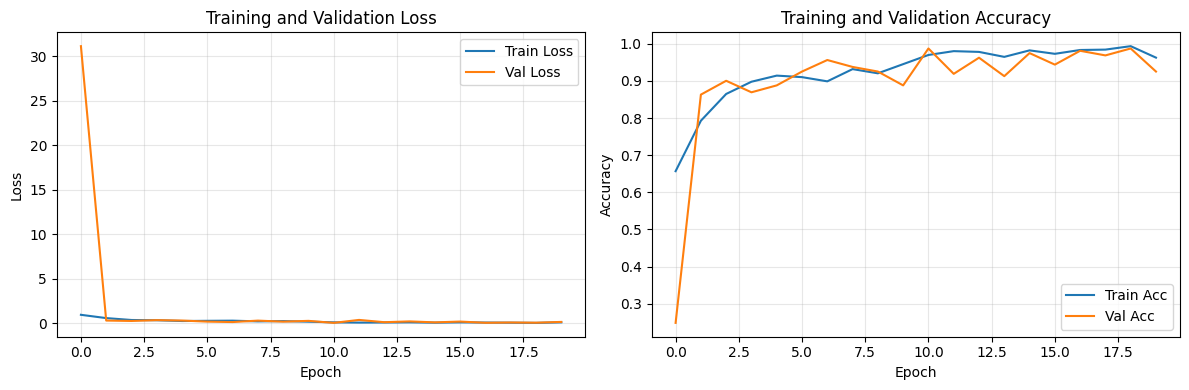

In [6]:
# Visualize Stage 1 results
plot_training_history(coarse_history, save_path='../figures/stage1_coarse_training.png')

Evaluating Stage 1 on test set...

Stage 1 Test Results:
  Accuracy:  0.8902
  Precision: 0.8956
  Recall:    0.8902
  F1-Score:  0.8835


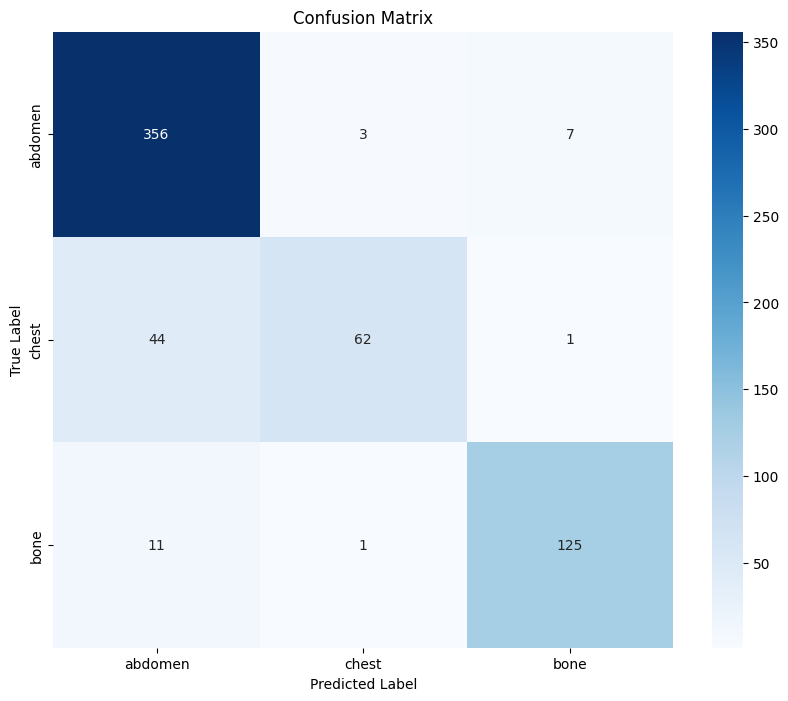

In [7]:
# Evaluate Stage 1 on test set
from utils.metrics import evaluate_model

print("Evaluating Stage 1 on test set...\n")
coarse_test_metrics, coarse_preds, coarse_labels = evaluate_model(
    coarse_model, coarse_test_loader, DEVICE
)

print("Stage 1 Test Results:")
print(f"  Accuracy:  {coarse_test_metrics['accuracy']:.4f}")
print(f"  Precision: {coarse_test_metrics['precision']:.4f}")
print(f"  Recall:    {coarse_test_metrics['recall']:.4f}")
print(f"  F1-Score:  {coarse_test_metrics['f1_score']:.4f}")

# Plot confusion matrix
region_names = list(ORGAN_TO_REGION_IDX.keys())
plot_confusion_matrix(
    coarse_test_metrics['confusion_matrix'],
    class_names=region_names,
    save_path='../figures/stage1_confusion_matrix.png'
)

In [8]:
print("="*60)
print("STAGE 2: Fine Pathology Classification")
print("="*60)

# Create region-to-organs mapping
region_to_organs = {'abdomen': {}, 'chest': {}, 'bone': {}}
for organ_idx, organ_name in ORGAN_CLASSES.items():
    region_name = ORGAN_TO_REGION[organ_name]
    region_to_organs[region_name][organ_idx] = organ_name

print("\nOrgans per region:")
for region, organs in region_to_organs.items():
    print(f"  {region}: {len(organs)} organs - {list(organs.values())}")

# For Stage 2, we'll train ONE model per region that classifies organs within that region


STAGE 2: Fine Pathology Classification

Organs per region:
  abdomen: 6 organs - ['bladder', 'kidney-left', 'kidney-right', 'liver', 'pancreas', 'spleen']
  chest: 3 organs - ['heart', 'lung-left', 'lung-right']
  bone: 2 organs - ['femur-left', 'femur-right']


In [9]:
# Create complete hierarchical model with new architectures
print("\n" + "="*60)
print("TRAINING FULL HIERARCHICAL MODEL")
print("="*60)

# Build region configs with actual organ counts
region_configs = {}
for region_name in ['abdomen', 'chest', 'bone']:
    num_organs = len(region_to_organs[region_name])
    region_configs[region_name] = num_organs

print(f"\nRegion configurations: {region_configs}")

# Get architectures from config
coarse_arch = MODEL_CONFIG['coarse_architecture']
fine_arch = MODEL_CONFIG['fine_architecture']

print(f"\n Stage 1 (Coarse): {coarse_arch.upper().replace('_', '-')}")
print(f" Stage 2 (Fine): {fine_arch.upper().replace('_', '-')}")

# Create hierarchical model with custom architectures
hierarchical_model = HierarchicalClassificationModel(
    region_configs=region_configs,
    coarse_model_type=coarse_arch,
    fine_model_type=fine_arch,
    dropout_rate=MODEL_CONFIG['dropout_rate'],
    organ_to_region_map=organ_to_region_map,
    num_total_organs=num_classes,
    region_idx_to_name=REGION_IDX_TO_NAME
).to(DEVICE)

# Load Stage 1 weights
hierarchical_model.coarse_classifier.model.load_state_dict(coarse_model.model.state_dict())
print("\n✓ Stage 1 weights loaded into hierarchical model")

# Verify the region mapping is correct
print(f"✓ Region mapping verified: {hierarchical_model.coarse_classifier.region_names}")

# Train Stage 2: Fine classifiers for each region
print("\n" + "="*60)
print("Training Stage 2: End-to-End Hierarchical Model")
print("="*60)

# Freeze Stage 1 (keep coarse classifier frozen)
for param in hierarchical_model.coarse_classifier.parameters():
    param.requires_grad = False

print("\n✓ Stage 1 frozen, training Stage 2 only")

# Setup training for the hierarchical model
hierarchical_criterion = nn.CrossEntropyLoss()
hierarchical_optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, hierarchical_model.parameters()),
    lr=TRAINING_CONFIG['learning_rate'],
    weight_decay=TRAINING_CONFIG['weight_decay']
)

hierarchical_scheduler = StepLR(
    hierarchical_optimizer,
    step_size=TRAINING_CONFIG['scheduler_step_size'],
    gamma=TRAINING_CONFIG['scheduler_gamma']
)

hierarchical_trainer = Trainer(
    model=hierarchical_model,
    train_loader=train_loader,  # Original organ-labeled data
    val_loader=val_loader,
    criterion=hierarchical_criterion,
    optimizer=hierarchical_optimizer,
    device=DEVICE,
    scheduler=hierarchical_scheduler
)

print(f"\n Training hierarchical model for {TRAINING_CONFIG['fine_epochs']} epochs...")
print("Stage 1 routes to regions, Stage 2 classifies organs within regions\n")

hierarchical_history = hierarchical_trainer.train(num_epochs=TRAINING_CONFIG['fine_epochs'])

print("\n Stage 2 Training Complete!")
print(f"Best hierarchical validation accuracy: {max(hierarchical_history['val_acc']):.4f}")


TRAINING FULL HIERARCHICAL MODEL

Region configurations: {'abdomen': 6, 'chest': 3, 'bone': 2}

 Stage 1 (Coarse): RESNET34-3D
 Stage 2 (Fine): RESNET34-3D

✓ Stage 1 weights loaded into hierarchical model
✓ Region mapping verified: {0: 'abdomen', 1: 'chest', 2: 'bone'}

Training Stage 2: End-to-End Hierarchical Model

✓ Stage 1 frozen, training Stage 2 only

 Training hierarchical model for 30 epochs...
Stage 1 routes to regions, Stage 2 classifies organs within regions


Epoch 1/30


Training:   0%|          | 0/31 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 28.00 MiB. GPU 0 has a total capacity of 7.65 GiB of which 52.62 MiB is free. Process 13099 has 1.31 GiB memory in use. Process 13316 has 154.00 MiB memory in use. Process 13466 has 1.54 GiB memory in use. Including non-PyTorch memory, this process has 4.04 GiB memory in use. Of the allocated memory 3.60 GiB is allocated by PyTorch, and 238.75 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

EVALUATING FULL HIERARCHICAL MODEL

Evaluating on test set...

Full Hierarchical Model Test Results:
  Accuracy:  0.2951
  Precision: 0.1265
  Recall:    0.2951
  F1-Score:  0.1689


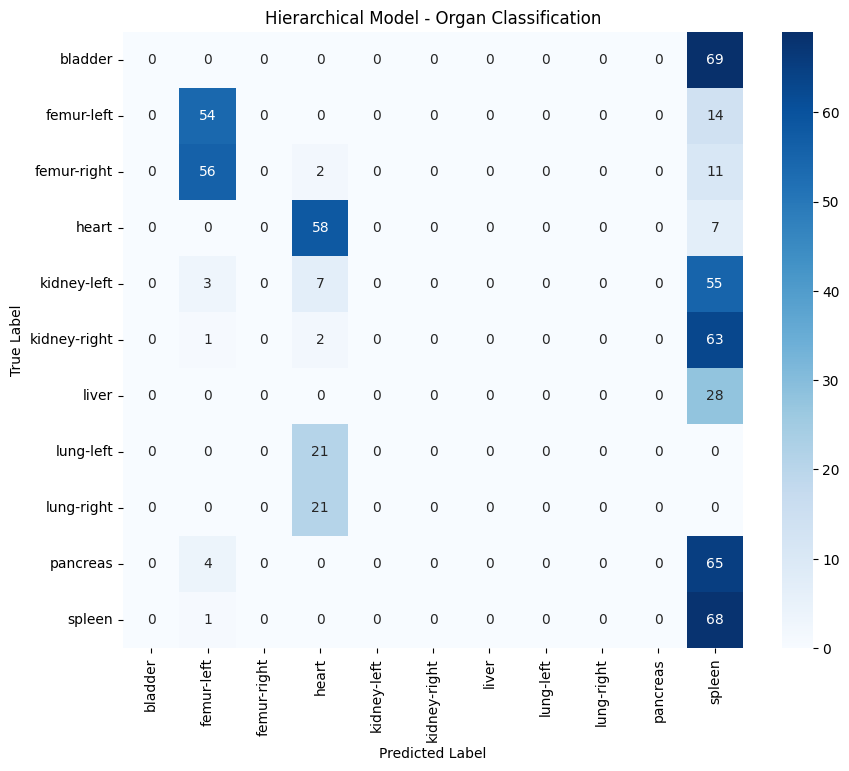


✓ Full hierarchical model evaluation complete


In [ ]:
# Evaluate Full Hierarchical Model

print("="*60)
print("EVALUATING FULL HIERARCHICAL MODEL")
print("="*60)

hierarchical_model.eval()

# Evaluate on test set
print("\nEvaluating on test set...")
hierarchical_test_metrics, hierarchical_preds, hierarchical_labels = evaluate_model(
    hierarchical_model, test_loader, DEVICE
)

print("\nFull Hierarchical Model Test Results:")
print(f"  Accuracy:  {hierarchical_test_metrics['accuracy']:.4f}")
print(f"  Precision: {hierarchical_test_metrics['precision']:.4f}")
print(f"  Recall:    {hierarchical_test_metrics['recall']:.4f}")
print(f"  F1-Score:  {hierarchical_test_metrics['f1_score']:.4f}")

# Plot confusion matrix
plot_confusion_matrix(
    hierarchical_test_metrics['confusion_matrix'],
    class_names=list(ORGAN_CLASSES.values()),
    save_path='../figures/hierarchical_confusion_matrix.png',
    title='Hierarchical Model - Organ Classification'
)

print("\n✓ Full hierarchical model evaluation complete")

In [ ]:
## Hierarchical vs Stage 1 Comparison

print("="*60)
print("COMPARISON: Stage 1 Only vs Full Hierarchical")
print("="*60)

print("\nStage 1 (Region Classification Only):")
print(f"  Number of classes: {len(ORGAN_TO_REGION_IDX)}")
print(f"  Test Accuracy: {coarse_test_metrics['accuracy']:.4f}")

print("\nFull Hierarchical (Stage 1 → Stage 2):")
print(f"  Number of classes: {num_classes}")
print(f"  Test Accuracy: {hierarchical_test_metrics['accuracy']:.4f}")

print("\n Key Insight:")
print("The hierarchical model performs end-to-end organ classification")
print("by first localizing the region (Stage 1), then classifying the")
print("specific organ within that region (Stage 2).")

COMPARISON: Stage 1 Only vs Full Hierarchical

Stage 1 (Region Classification Only):
  Number of classes: 3
  Test Accuracy: 0.9131

Full Hierarchical (Stage 1 → Stage 2):
  Number of classes: 11
  Test Accuracy: 0.2951

 Key Insight:
The hierarchical model performs end-to-end organ classification
by first localizing the region (Stage 1), then classifying the
specific organ within that region (Stage 2).


In [ ]:
# Demo: Hierarchical prediction on test samples
hierarchical_model.eval()

# Get a batch of test images
test_images, test_organ_labels = next(iter(test_loader))
test_images = test_images.to(DEVICE, dtype=torch.float32)
if test_images.max() > 1:
    test_images = test_images / 255.0

with torch.no_grad():
    # Stage 1: Predict anatomical region
    region_idx, region_names, region_conf = hierarchical_model.coarse_classifier.predict_region(
        test_images
    )

print("Hierarchical Prediction Example:")
print("="*60)
for i in range(min(5, len(test_images))):
    true_organ = ORGAN_CLASSES[test_organ_labels[i].item()]
    pred_region = region_names[i]
    region_confidence = region_conf[i].item()
    true_region = ORGAN_TO_REGION[true_organ]
    
    print(f"\nSample {i+1}:")
    print(f"  True organ: {true_organ} (region: {true_region})")
    print(f"  Predicted region: {pred_region} (confidence: {region_confidence:.3f})")
    print(f"  Region correct: {pred_region == true_region}")

Hierarchical Prediction Example:

Sample 1:
  True organ: spleen (region: abdomen)
  Predicted region: abdomen (confidence: 0.999)
  Region correct: True

Sample 2:
  True organ: femur-right (region: bone)
  Predicted region: bone (confidence: 1.000)
  Region correct: True

Sample 3:
  True organ: heart (region: chest)
  Predicted region: chest (confidence: 1.000)
  Region correct: True

Sample 4:
  True organ: kidney-left (region: abdomen)
  Predicted region: abdomen (confidence: 0.990)
  Region correct: True

Sample 5:
  True organ: pancreas (region: abdomen)
  Predicted region: abdomen (confidence: 1.000)
  Region correct: True


In [ ]:
# Save FULL hierarchical model
import os
os.makedirs('../models', exist_ok=True)

torch.save({
    'coarse_model_state': coarse_model.state_dict(),
    'hierarchical_model_state': hierarchical_model.state_dict(),
    'coarse_history': coarse_history,
    'hierarchical_history': hierarchical_history,
    'coarse_test_metrics': coarse_test_metrics,
    'hierarchical_test_metrics': hierarchical_test_metrics,
    'region_configs': region_configs,
    'organ_to_region_map': organ_to_region_map,
    'region_to_organs': region_to_organs,
}, '../models/hierarchical_model.pth')

print("✓ FULL Hierarchical model saved to '../models/hierarchical_model.pth'")
print("\nSaved components:")
print("  - Stage 1 coarse classifier (region localization)")
print("  - Stage 2 fine classifiers (region-specific organ classification)")
print("  - Complete hierarchical pipeline")
print("  - Training histories and test metrics")

✓ FULL Hierarchical model saved to '../models/hierarchical_model.pth'

Saved components:
  - Stage 1 coarse classifier (region localization)
  - Stage 2 fine classifiers (region-specific organ classification)
  - Complete hierarchical pipeline
  - Training histories and test metrics


# K-Fold Cross-Validation with AUC Metrics

This section implements k-fold cross-validation for both Stage 1 (coarse region classification) and the full hierarchical model, with AUC (Area Under the ROC Curve) measurement.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import copy

# Configuration for k-fold cross-validation
K_FOLDS = 5
KFOLD_EPOCHS_COARSE = 15  # Reduced epochs for faster k-fold
KFOLD_EPOCHS_FINE = 20

print(f"K-Fold Cross-Validation Configuration:")
print(f"  Number of folds: {K_FOLDS}")
print(f"  Epochs per fold (Stage 1): {KFOLD_EPOCHS_COARSE}")
print(f"  Epochs per fold (Hierarchical): {KFOLD_EPOCHS_FINE}")

In [ ]:
# Prepare full dataset for k-fold (combine train + val)
from torch.utils.data import ConcatDataset, Subset, DataLoader

# Combine train and val datasets
full_dataset = ConcatDataset([train_loader.dataset, val_loader.dataset])

# Extract all labels for stratification
all_labels = []
for i in range(len(full_dataset)):
    _, label = full_dataset[i]
    all_labels.append(label.item())

all_labels = np.array(all_labels)

print(f"Total samples for k-fold: {len(full_dataset)}")
print(f"Label distribution: {np.bincount(all_labels)}")

In [ ]:
def compute_auc_metrics(model, data_loader, device, num_classes, task_name="classification"):
    """
    Compute AUC metrics for multi-class classification.
    Returns both macro and weighted AUC scores.
    """
    model.eval()
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.to(device, dtype=torch.float32)
            if imgs.max() > 1:
                imgs = imgs / 255.0
            
            labels = labels.view(-1)
            
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Binarize labels for multi-class AUC
    labels_binarized = label_binarize(all_labels, classes=range(num_classes))
    
    # Compute AUC scores
    try:
        auc_macro = roc_auc_score(labels_binarized, all_probs, average='macro', multi_class='ovr')
        auc_weighted = roc_auc_score(labels_binarized, all_probs, average='weighted', multi_class='ovr')
    except ValueError as e:
        print(f"Warning: Could not compute AUC - {e}")
        auc_macro = 0.0
        auc_weighted = 0.0
    
    # Compute per-class AUC
    per_class_auc = []
    for i in range(num_classes):
        if len(np.unique(labels_binarized[:, i])) > 1:  # Check if class exists in this fold
            try:
                class_auc = roc_auc_score(labels_binarized[:, i], all_probs[:, i])
                per_class_auc.append(class_auc)
            except:
                per_class_auc.append(0.0)
        else:
            per_class_auc.append(0.0)
    
    return {
        'auc_macro': auc_macro,
        'auc_weighted': auc_weighted,
        'per_class_auc': per_class_auc,
        'all_labels': all_labels,
        'all_probs': all_probs
    }

print("✓ AUC computation function defined")

## K-Fold Cross-Validation: Stage 1 (Coarse Region Classification)

In [ ]:
print("="*60)
print("K-FOLD CROSS-VALIDATION: STAGE 1 (COARSE)")
print("="*60)

# Convert organ labels to region labels for stratification
region_labels = np.array([organ_to_region_map[label] for label in all_labels])

# Initialize k-fold
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

# Store results for each fold
coarse_kfold_results = {
    'fold_accuracies': [],
    'fold_auc_macro': [],
    'fold_auc_weighted': [],
    'fold_histories': []
}

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(region_labels)), region_labels)):
    print(f"\n{'='*60}")
    print(f"FOLD {fold + 1}/{K_FOLDS}")
    print(f"{'='*60}")
    
    # Create data loaders for this fold
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)
    
    fold_train_loader = DataLoader(
        train_subset,
        batch_size=DATA_CONFIG['batch_size'],
        shuffle=True,
        num_workers=DATA_CONFIG['num_workers']
    )
    fold_val_loader = DataLoader(
        val_subset,
        batch_size=DATA_CONFIG['batch_size'],
        shuffle=False,
        num_workers=DATA_CONFIG['num_workers']
    )
    
    # Wrap with region labels
    fold_train_region_loader = RegionDataLoader(fold_train_loader, organ_to_region_map)
    fold_val_region_loader = RegionDataLoader(fold_val_loader, organ_to_region_map)
    
    print(f"Train samples: {len(train_idx)}, Val samples: {len(val_idx)}")
    
    # Create fresh model for this fold
    fold_coarse_model = CoarseAnatomicalClassifier(
        architecture=MODEL_CONFIG['coarse_architecture'],
        num_regions=num_regions,
        dropout_rate=MODEL_CONFIG['dropout_rate'],
        region_names=REGION_IDX_TO_NAME
    ).to(DEVICE)
    
    # Setup optimizer and scheduler
    fold_optimizer = optim.Adam(
        fold_coarse_model.parameters(),
        lr=TRAINING_CONFIG['learning_rate'],
        weight_decay=TRAINING_CONFIG['weight_decay']
    )
    fold_scheduler = StepLR(
        fold_optimizer,
        step_size=TRAINING_CONFIG['scheduler_step_size'],
        gamma=TRAINING_CONFIG['scheduler_gamma']
    )
    
    # Train
    fold_trainer = Trainer(
        model=fold_coarse_model,
        train_loader=fold_train_region_loader,
        val_loader=fold_val_region_loader,
        criterion=nn.CrossEntropyLoss(),
        optimizer=fold_optimizer,
        device=DEVICE,
        scheduler=fold_scheduler
    )
    
    torch.cuda.empty_cache()
    fold_history = fold_trainer.train(num_epochs=KFOLD_EPOCHS_COARSE)
    
    # Evaluate on validation set
    val_metrics, _, _ = evaluate_model(fold_coarse_model, fold_val_region_loader, DEVICE)
    
    # Compute AUC
    auc_results = compute_auc_metrics(
        fold_coarse_model,
        fold_val_region_loader,
        DEVICE,
        num_regions,
        task_name="coarse"
    )
    
    # Store results
    coarse_kfold_results['fold_accuracies'].append(val_metrics['accuracy'])
    coarse_kfold_results['fold_auc_macro'].append(auc_results['auc_macro'])
    coarse_kfold_results['fold_auc_weighted'].append(auc_results['auc_weighted'])
    coarse_kfold_results['fold_histories'].append(fold_history)
    
    print(f"\nFold {fold + 1} Results:")
    print(f"  Accuracy: {val_metrics['accuracy']:.4f}")
    print(f"  AUC (macro): {auc_results['auc_macro']:.4f}")
    print(f"  AUC (weighted): {auc_results['auc_weighted']:.4f}")
    
    # Clean up
    del fold_coarse_model, fold_optimizer, fold_scheduler, fold_trainer
    torch.cuda.empty_cache()

print(f"\n{'='*60}")
print("STAGE 1 K-FOLD RESULTS SUMMARY")
print(f"{'='*60}")
print(f"Accuracy: {np.mean(coarse_kfold_results['fold_accuracies']):.4f} ± {np.std(coarse_kfold_results['fold_accuracies']):.4f}")
print(f"AUC (macro): {np.mean(coarse_kfold_results['fold_auc_macro']):.4f} ± {np.std(coarse_kfold_results['fold_auc_macro']):.4f}")
print(f"AUC (weighted): {np.mean(coarse_kfold_results['fold_auc_weighted']):.4f} ± {np.std(coarse_kfold_results['fold_auc_weighted']):.4f}")

## K-Fold Cross-Validation: Full Hierarchical Model

In [ ]:
print("="*60)
print("K-FOLD CROSS-VALIDATION: HIERARCHICAL MODEL")
print("="*60)

# Initialize k-fold with organ labels
skf_organ = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

# Store results for each fold
hierarchical_kfold_results = {
    'fold_accuracies': [],
    'fold_auc_macro': [],
    'fold_auc_weighted': [],
    'fold_histories': []
}

for fold, (train_idx, val_idx) in enumerate(skf_organ.split(np.zeros(len(all_labels)), all_labels)):
    print(f"\n{'='*60}")
    print(f"FOLD {fold + 1}/{K_FOLDS}")
    print(f"{'='*60}")
    
    # Create data loaders for this fold
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)
    
    fold_train_loader = DataLoader(
        train_subset,
        batch_size=DATA_CONFIG['batch_size'],
        shuffle=True,
        num_workers=DATA_CONFIG['num_workers']
    )
    fold_val_loader = DataLoader(
        val_subset,
        batch_size=DATA_CONFIG['batch_size'],
        shuffle=False,
        num_workers=DATA_CONFIG['num_workers']
    )
    
    print(f"Train samples: {len(train_idx)}, Val samples: {len(val_idx)}")
    
    # Step 1: Train coarse classifier
    print(f"\n Training Stage 1 (Coarse) for fold {fold + 1}...")
    
    fold_train_region_loader = RegionDataLoader(fold_train_loader, organ_to_region_map)
    fold_val_region_loader = RegionDataLoader(fold_val_loader, organ_to_region_map)
    
    fold_coarse_model = CoarseAnatomicalClassifier(
        architecture=MODEL_CONFIG['coarse_architecture'],
        num_regions=num_regions,
        dropout_rate=MODEL_CONFIG['dropout_rate'],
        region_names=REGION_IDX_TO_NAME
    ).to(DEVICE)
    
    fold_coarse_optimizer = optim.Adam(
        fold_coarse_model.parameters(),
        lr=TRAINING_CONFIG['learning_rate'],
        weight_decay=TRAINING_CONFIG['weight_decay']
    )
    fold_coarse_scheduler = StepLR(
        fold_coarse_optimizer,
        step_size=TRAINING_CONFIG['scheduler_step_size'],
        gamma=TRAINING_CONFIG['scheduler_gamma']
    )
    
    fold_coarse_trainer = Trainer(
        model=fold_coarse_model,
        train_loader=fold_train_region_loader,
        val_loader=fold_val_region_loader,
        criterion=nn.CrossEntropyLoss(),
        optimizer=fold_coarse_optimizer,
        device=DEVICE,
        scheduler=fold_coarse_scheduler
    )
    
    torch.cuda.empty_cache()
    _ = fold_coarse_trainer.train(num_epochs=KFOLD_EPOCHS_COARSE)
    
    # Step 2: Create and train hierarchical model
    print(f"\n Training Stage 2 (Hierarchical) for fold {fold + 1}...")
    
    fold_hierarchical_model = HierarchicalClassificationModel(
        region_configs=region_configs,
        coarse_model_type=MODEL_CONFIG['coarse_architecture'],
        fine_model_type=MODEL_CONFIG['fine_architecture'],
        dropout_rate=MODEL_CONFIG['dropout_rate'],
        organ_to_region_map=organ_to_region_map,
        num_total_organs=num_classes,
        region_idx_to_name=REGION_IDX_TO_NAME
    ).to(DEVICE)
    
    # Load coarse weights
    fold_hierarchical_model.coarse_classifier.model.load_state_dict(
        fold_coarse_model.model.state_dict()
    )
    
    # Freeze Stage 1
    for param in fold_hierarchical_model.coarse_classifier.parameters():
        param.requires_grad = False
    
    # Train Stage 2
    fold_hierarchical_optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, fold_hierarchical_model.parameters()),
        lr=TRAINING_CONFIG['learning_rate'],
        weight_decay=TRAINING_CONFIG['weight_decay']
    )
    fold_hierarchical_scheduler = StepLR(
        fold_hierarchical_optimizer,
        step_size=TRAINING_CONFIG['scheduler_step_size'],
        gamma=TRAINING_CONFIG['scheduler_gamma']
    )
    
    fold_hierarchical_trainer = Trainer(
        model=fold_hierarchical_model,
        train_loader=fold_train_loader,
        val_loader=fold_val_loader,
        criterion=nn.CrossEntropyLoss(),
        optimizer=fold_hierarchical_optimizer,
        device=DEVICE,
        scheduler=fold_hierarchical_scheduler
    )
    
    torch.cuda.empty_cache()
    fold_history = fold_hierarchical_trainer.train(num_epochs=KFOLD_EPOCHS_FINE)
    
    # Evaluate on validation set
    val_metrics, _, _ = evaluate_model(fold_hierarchical_model, fold_val_loader, DEVICE)
    
    # Compute AUC
    auc_results = compute_auc_metrics(
        fold_hierarchical_model,
        fold_val_loader,
        DEVICE,
        num_classes,
        task_name="hierarchical"
    )
    
    # Store results
    hierarchical_kfold_results['fold_accuracies'].append(val_metrics['accuracy'])
    hierarchical_kfold_results['fold_auc_macro'].append(auc_results['auc_macro'])
    hierarchical_kfold_results['fold_auc_weighted'].append(auc_results['auc_weighted'])
    hierarchical_kfold_results['fold_histories'].append(fold_history)
    
    print(f"\nFold {fold + 1} Hierarchical Results:")
    print(f"  Accuracy: {val_metrics['accuracy']:.4f}")
    print(f"  AUC (macro): {auc_results['auc_macro']:.4f}")
    print(f"  AUC (weighted): {auc_results['auc_weighted']:.4f}")
    
    # Clean up
    del fold_coarse_model, fold_hierarchical_model
    del fold_coarse_optimizer, fold_hierarchical_optimizer
    del fold_coarse_scheduler, fold_hierarchical_scheduler
    del fold_coarse_trainer, fold_hierarchical_trainer
    torch.cuda.empty_cache()

print(f"\n{'='*60}")
print("HIERARCHICAL MODEL K-FOLD RESULTS SUMMARY")
print(f"{'='*60}")
print(f"Accuracy: {np.mean(hierarchical_kfold_results['fold_accuracies']):.4f} ± {np.std(hierarchical_kfold_results['fold_accuracies']):.4f}")
print(f"AUC (macro): {np.mean(hierarchical_kfold_results['fold_auc_macro']):.4f} ± {np.std(hierarchical_kfold_results['fold_auc_macro']):.4f}")
print(f"AUC (weighted): {np.mean(hierarchical_kfold_results['fold_auc_weighted']):.4f} ± {np.std(hierarchical_kfold_results['fold_auc_weighted']):.4f}")

## Visualize K-Fold Results

In [ ]:
# Plot k-fold results comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Accuracy across folds
axes[0].plot(range(1, K_FOLDS + 1), coarse_kfold_results['fold_accuracies'], 
             marker='o', label='Stage 1 (Coarse)', linewidth=2, markersize=8)
axes[0].plot(range(1, K_FOLDS + 1), hierarchical_kfold_results['fold_accuracies'], 
             marker='s', label='Hierarchical', linewidth=2, markersize=8)
axes[0].axhline(y=np.mean(coarse_kfold_results['fold_accuracies']), 
                color='blue', linestyle='--', alpha=0.5, label='Coarse Mean')
axes[0].axhline(y=np.mean(hierarchical_kfold_results['fold_accuracies']), 
                color='orange', linestyle='--', alpha=0.5, label='Hierarchical Mean')
axes[0].set_xlabel('Fold', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy Across K-Folds', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(1, K_FOLDS + 1))

# Plot 2: AUC (macro) across folds
axes[1].plot(range(1, K_FOLDS + 1), coarse_kfold_results['fold_auc_macro'], 
             marker='o', label='Stage 1 (Coarse)', linewidth=2, markersize=8)
axes[1].plot(range(1, K_FOLDS + 1), hierarchical_kfold_results['fold_auc_macro'], 
             marker='s', label='Hierarchical', linewidth=2, markersize=8)
axes[1].axhline(y=np.mean(coarse_kfold_results['fold_auc_macro']), 
                color='blue', linestyle='--', alpha=0.5, label='Coarse Mean')
axes[1].axhline(y=np.mean(hierarchical_kfold_results['fold_auc_macro']), 
                color='orange', linestyle='--', alpha=0.5, label='Hierarchical Mean')
axes[1].set_xlabel('Fold', fontsize=12)
axes[1].set_ylabel('AUC (Macro)', fontsize=12)
axes[1].set_title('AUC (Macro) Across K-Folds', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(range(1, K_FOLDS + 1))

# Plot 3: AUC (weighted) across folds
axes[2].plot(range(1, K_FOLDS + 1), coarse_kfold_results['fold_auc_weighted'], 
             marker='o', label='Stage 1 (Coarse)', linewidth=2, markersize=8)
axes[2].plot(range(1, K_FOLDS + 1), hierarchical_kfold_results['fold_auc_weighted'], 
             marker='s', label='Hierarchical', linewidth=2, markersize=8)
axes[2].axhline(y=np.mean(coarse_kfold_results['fold_auc_weighted']), 
                color='blue', linestyle='--', alpha=0.5, label='Coarse Mean')
axes[2].axhline(y=np.mean(hierarchical_kfold_results['fold_auc_weighted']), 
                color='orange', linestyle='--', alpha=0.5, label='Hierarchical Mean')
axes[2].set_xlabel('Fold', fontsize=12)
axes[2].set_ylabel('AUC (Weighted)', fontsize=12)
axes[2].set_title('AUC (Weighted) Across K-Folds', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(range(1, K_FOLDS + 1))

plt.tight_layout()
plt.savefig('../figures/kfold_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ K-fold comparison plot saved to '../figures/kfold_comparison.png'")

In [ ]:
# Summary statistics table
import pandas as pd

summary_data = {
    'Metric': ['Accuracy', 'AUC (Macro)', 'AUC (Weighted)'],
    'Stage 1 Mean': [
        f"{np.mean(coarse_kfold_results['fold_accuracies']):.4f}",
        f"{np.mean(coarse_kfold_results['fold_auc_macro']):.4f}",
        f"{np.mean(coarse_kfold_results['fold_auc_weighted']):.4f}"
    ],
    'Stage 1 Std': [
        f"{np.std(coarse_kfold_results['fold_accuracies']):.4f}",
        f"{np.std(coarse_kfold_results['fold_auc_macro']):.4f}",
        f"{np.std(coarse_kfold_results['fold_auc_weighted']):.4f}"
    ],
    'Hierarchical Mean': [
        f"{np.mean(hierarchical_kfold_results['fold_accuracies']):.4f}",
        f"{np.mean(hierarchical_kfold_results['fold_auc_macro']):.4f}",
        f"{np.mean(hierarchical_kfold_results['fold_auc_weighted']):.4f}"
    ],
    'Hierarchical Std': [
        f"{np.std(hierarchical_kfold_results['fold_accuracies']):.4f}",
        f"{np.std(hierarchical_kfold_results['fold_auc_macro']):.4f}",
        f"{np.std(hierarchical_kfold_results['fold_auc_weighted']):.4f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("K-FOLD CROSS-VALIDATION SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

In [ ]:
# Save k-fold results
kfold_save_path = '../models/kfold_results.pth'

torch.save({
    'coarse_kfold_results': coarse_kfold_results,
    'hierarchical_kfold_results': hierarchical_kfold_results,
    'k_folds': K_FOLDS,
    'kfold_epochs_coarse': KFOLD_EPOCHS_COARSE,
    'kfold_epochs_fine': KFOLD_EPOCHS_FINE,
    'summary_df': summary_df
}, kfold_save_path)

print(f"✓ K-fold results saved to '{kfold_save_path}'")